In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
from glob import glob

In [2]:
def concatenate_onyx_data(filelist):
    '''
    Concatenate ONYX data from multiple HDF5 files.
    '''
    for i,file in enumerate(filelist):
        data = h5py.File(file)
        if i==0:
            attrs=dict(data['Acquisition'].attrs)
            dt = 1/attrs['MaximumFrequency']/2
            dx = attrs['SpatialSamplingInterval']
            das = np.array(data['Acquisition/Raw[0]/RawData'])
            time = np.array(data['Acquisition/Raw[0]/RawDataTime'])
            nt,nx = das.shape
        else:
            das = np.vstack((das,np.array(data['Acquisition/Raw[0]/RawData'])))
            time = np.hstack((time,np.array(data['Acquisition/Raw[0]/RawDataTime'])))
            nt += nt
        data.close()

    return das, time, dt, dx, nt, nx, attrs

In [3]:
'''
This is a bit of a special case where we have two cables that were recorded simulataneously
and we want to concatenate them side by side into one big array.
We also contatenate in time by reading multiple files for each cable.
'''

paths = ['/1-fnp/petasaur/p-jbod1/cidas/incoming/TERRA_FiberA_25Hz/',
         '/1-fnp/petasaur/p-jbod1/cidas/incoming/KKFL-S_FIberA_25Hz/']

for i,path in enumerate(paths):
    filelist = glob(path+'decimator2_2023-07-16_06.48*')
    filelist = filelist + glob(path+'decimator2_2023-07-16_06.49*')
    filelist = filelist + glob(path+'decimator2_2023-07-16_06.5*')
    filelist = sorted(filelist)
    thisdas, time, dt, dx, nt, thisnx, attrs = concatenate_onyx_data(filelist)
    if i==0:
        das = thisdas
        nx = thisnx
    else:
        das = np.hstack((das,np.fliplr(thisdas)))
        nx += thisnx

x = np.linspace(0,nx*dx,nx)
t = np.linspace(0,nt*dt,nt)

In [4]:
b,a = butter(2,0.01,'high',fs=1/dt)
data_hf = filtfilt(b,a,das,axis=0)

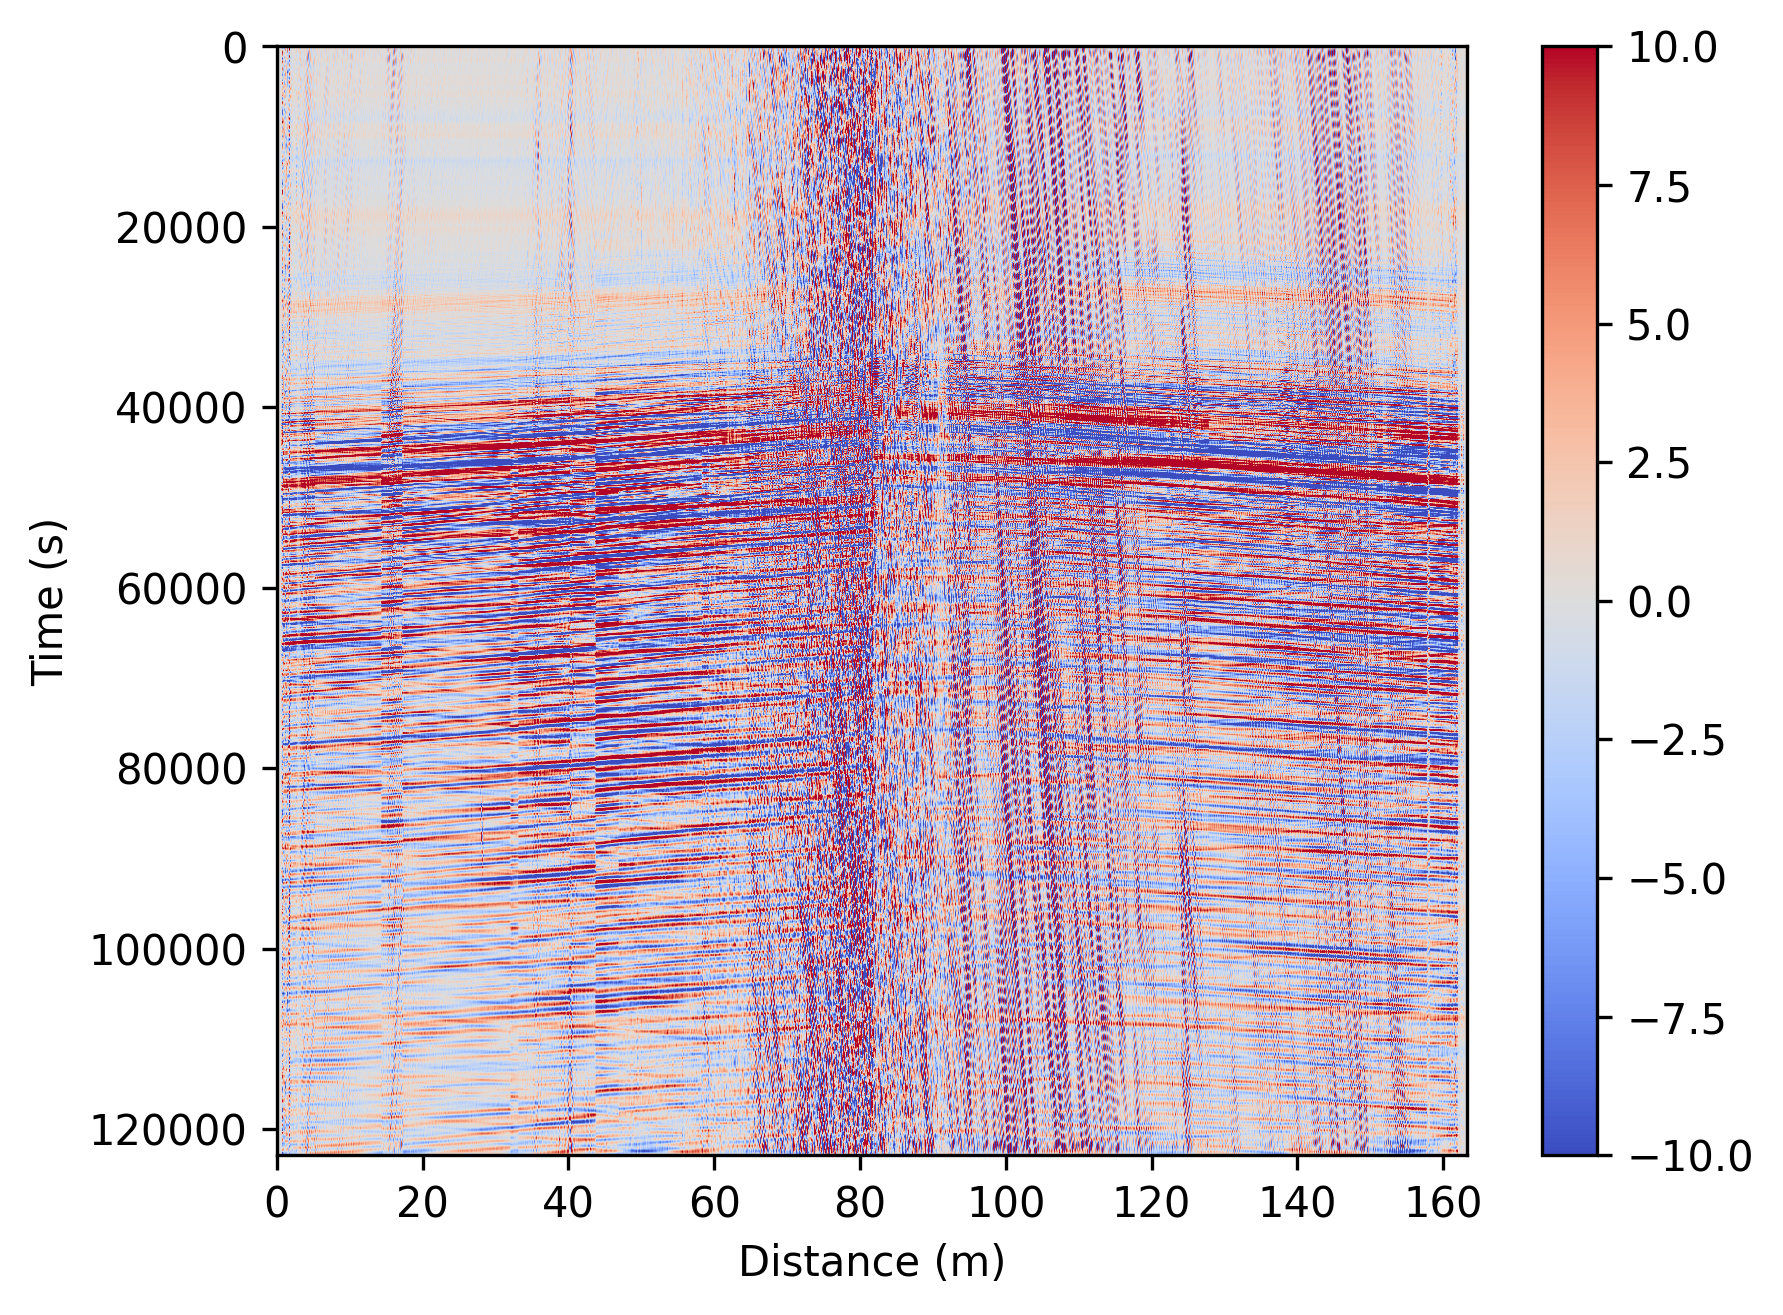

In [6]:
vm = 10
plt.subplots(dpi=300)
c=plt.imshow(data_hf,aspect='auto',cmap='coolwarm',
             vmin=-vm,vmax=vm,extent=[x[0]/1e3,x[-1]/1e3,t[-1],t[0]])
plt.colorbar(c)
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')
plt.show()